In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as md
import seaborn as sns
import datetime, warnings
import sqlite3
import glob
import numpy as np
from scipy import stats
from scipy.stats import ttest_ind

In [3]:
path = r'C:\Users\Ryan Lo\OneDrive\Documents\Projects\Yammer_Analysis\datasets' # use your path
all_files = glob.glob(path + "/*.csv")

csvs = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    csvs.append(df)


In [4]:
emails_tbl = """ CREATE TABLE IF NOT EXISTS emails (
                    user_id INTEGER,
                    occurred_at DATETIME NOT NULL,
                    action TEXT,
                    user_type INTEGER,
                    PRIMARY KEY (user_id, occurred_at)
                ); """

events_tbl = """CREATE TABLE IF NOT EXISTS events (
                    user_id INTEGER PRIMARY KEY,
                    occured_at DATETIME NOT NULL,
                    event_type TEXT,
                    event_name TEXT,
                    location TEXT,
                    device TEXT,
                    user_type INTEGER
                );"""

experiments_tbl = """CREATE TABLE IF NOT EXISTS experiments (
                    user_id INTEGER PRIMARY KEY,
                    occured_at DATETIME NOT NULL,
                    experiment TEXT,
                    experiment_group TEXT,
                    location TEXT,
                    device TEXT,
                    user_type INTEGER
                );"""

users_tbl = """CREATE TABLE IF NOT EXISTS users (
                    user_id INTEGER PRIMARY KEY,
                    created_at DATETIME NOT NULL,
                    company_id INTEGER,
                    language TEXT,
                    activated_at DATETIME,
                    state TEXT
                );"""

queries_list = [emails_tbl, events_tbl, experiments_tbl, users_tbl]

In [5]:
def create_table(conn, create_table_sql):
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)

In [6]:
table_names = ["emails", "events", "experiments", "users"]
conn = sqlite3.connect('yammer.db')

for queries in queries_list:
    create_table(conn, queries)
    
for count, csv in enumerate(csvs):
    conn.execute("DROP TABLE IF EXISTS {};".format(table_names[count]))
    csv.to_sql(table_names[count], conn)

In [7]:
q = '''
SELECT *
FROM events;
'''

pd.read_sql(q,conn)

index  user_id          occurred_at  event_type    event_name  \
0            0  10522.0  2014-05-02 11:02:39  engagement         login   
1            1  10522.0  2014-05-02 11:02:53  engagement     home_page   
2            2  10522.0  2014-05-02 11:03:28  engagement  like_message   
3            3  10522.0  2014-05-02 11:04:09  engagement    view_inbox   
4            4  10522.0  2014-05-02 11:03:16  engagement    search_run   
...        ...      ...                  ...         ...           ...   
340827  340827  18815.0  2014-08-31 13:41:46  engagement  like_message   
340828  340828  18815.0  2014-08-31 13:42:11  engagement     home_page   
340829  340829  18815.0  2014-08-31 13:42:43  engagement  send_message   
340830  340830  18815.0  2014-08-31 13:43:07  engagement     home_page   
340831  340831  18815.0  2014-08-31 13:43:42  engagement  like_message   

       location                  device  user_type  
0         Japan  dell inspiron notebook        3.0  
1         Japan  dell inspiron notebook        3.0  
2         Japan  dell inspiron notebook        3.0  
3         Japan  dell inspiron notebook        3.0  
4         Japan  dell inspiron notebook        3.0  
...         ...                     ...        ...  
340827  Ireland  dell inspiron notebook        2.0  
340828  Ireland  dell inspiron notebook        2.0  
340829  Ireland  dell inspiron notebook        2.0  
340830  Ireland  dell inspiron notebook        2.0  
340831  Ireland  dell inspiron notebook        2.0  

[340832 rows x 8 columns]

## Section 1 - Investigating a Drop in User Engagement

Possible reasons for decrease in user engagment
- broken function (device specific, feature specific)
- competitors taking users
- holidays
- locational
- traffic anomalies in the past
- past highs in engagement can be due to marketing campaigns that artificially pushes engagement
- lack of retention from older users

In [8]:
q = '''
SELECT created_at, 
strftime('%d', created_at) as Day, 
strftime('%m', created_at) as Month, 
COUNT(CASE WHEN state = 'active' THEN user_id ELSE NULL END) as Activated_Users,
COUNT(user_id) as All_Users
FROM users
WHERE strftime('%Y', created_at) > '2013'
GROUP BY Month, Day
ORDER BY created_at
;
''' 
user_activity = pd.read_sql(q,conn)
user_activity

created_at Day Month  Activated_Users  All_Users
0    2014-01-01 16:59:00  01    01               16         35
1    2014-01-02 20:16:21  02    01               35         54
2    2014-01-03 08:23:17  03    01               25         45
3    2014-01-04 12:10:53  04    01                7         11
4    2014-01-05 17:26:10  05    01                8         11
..                   ...  ..   ...              ...        ...
238  2014-08-27 08:00:23  27    08               48         90
239  2014-08-28 15:05:55  28    08               50         95
240  2014-08-29 15:18:44  29    08               45         97
241  2014-08-30 15:34:34  30    08               12         26
242  2014-08-31 05:22:16  31    08               18         32

[243 rows x 5 columns]

(array([ -9.,  -2.,   5.,  12.,  19.,  26.,  33.,  40.,  47.,  54.,  61.,
         68.,  75.,  82.,  89.,  96., 103., 110., 117., 124., 131., 138.,
        145., 152., 159., 166., 173., 180., 187., 194., 201., 208., 215.,
        222., 229., 236., 243., 250.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

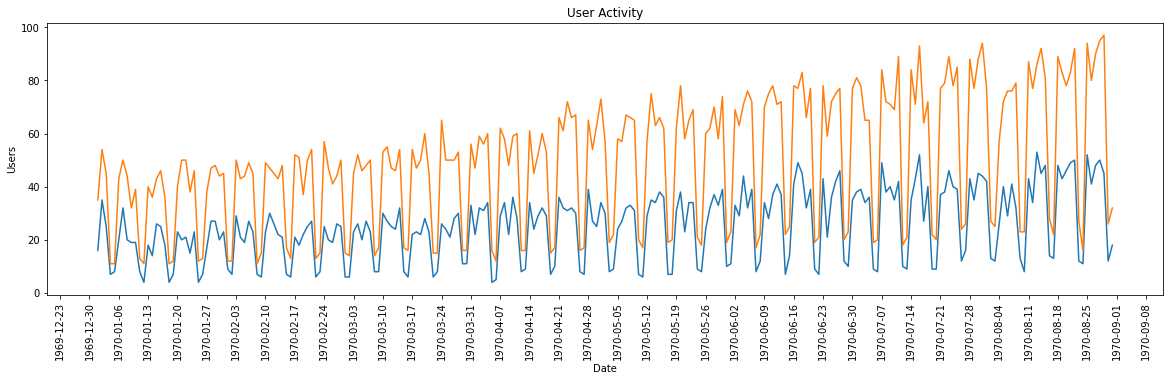

In [9]:
#Graph
warnings.filterwarnings('ignore')
fig, ax = plt.subplots(figsize=(20,5))
sns.lineplot(user_activity.index, user_activity.Activated_Users, palette="Purples_r")
sns.lineplot(user_activity.index, user_activity.All_Users, palette="Red")
plt.ylabel("Users")
plt.xlabel("Date")
plt.title("User Activity")
ax.xaxis.set_major_locator(md.WeekdayLocator(byweekday = 1))
# specify the format of the labels as 'year-month-day'
ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%m-%d')) 
# (optional) rotate by 90° the labels in order to improve their spacing
plt.setp(ax.xaxis.get_majorticklabels(), rotation = 90)
plt.xticks(rotation=90)

In [10]:
q = '''
SELECT DISTINCT event_name
FROM events
;
''' 
pd.read_sql(q,conn)

event_name
0                    login
1                home_page
2             like_message
3               view_inbox
4               search_run
5             send_message
6      search_autocomplete
7   search_click_result_10
8              create_user
9              enter_email
10              enter_info
11         complete_signup
12   search_click_result_7
13   search_click_result_8
14   search_click_result_1
15   search_click_result_3
16   search_click_result_2
17   search_click_result_5
18   search_click_result_6
19   search_click_result_9
20   search_click_result_4

In [11]:
q = '''
SELECT
strftime('%d', occurred_at) as Day, 
strftime('%m', occurred_at) as Month,
COUNT(CASE WHEN event_name = 'login' THEN event_name ELSE NULL END) as Login_count,
COUNT(CASE WHEN event_name = 'home_page' THEN event_name ELSE NULL END) as Home_page_count,
COUNT(CASE WHEN event_name = 'view_inbox' THEN event_name ELSE NULL END) as View_inbox_count,
COUNT(CASE WHEN event_name = 'like_message' THEN event_name ELSE NULL END) as Like_message_count,
COUNT(CASE WHEN event_name = 'send_message' THEN event_name ELSE NULL END) as Send_message_count,
COUNT(CASE WHEN event_name LIKE 'search_click_result_%' THEN event_name ELSE NULL END) as click_count
FROM events
GROUP BY MONTH, DAY
;
''' 
event_action = pd.read_sql(q,conn)
event_action

Day Month  Login_count  Home_page_count  View_inbox_count  \
0    01    05          333              832               472   
1    02    05          408             1165               682   
2    03    05          146              344               222   
3    04    05           80              205               134   
4    05    05          286              736               434   
..   ..   ...          ...              ...               ...   
118  27    08          327              764               481   
119  28    08          352              802               477   
120  29    08          445             1031               618   
121  30    08          177              426               258   
122  31    08          104              209               142   

     Like_message_count  Send_message_count  click_count  
0                   539                 284          135  
1                   754                 416          119  
2                   227                 126           81  
3                   137                  78            8  
4                   499                 297           96  
..                  ...                 ...          ...  
118                 443                 266           68  
119                 501                 280           93  
120                 612                 340           80  
121                 255                 152           29  
122                 111                  60           17  

[123 rows x 8 columns]

Text(0.5, 1.0, 'User Activity')

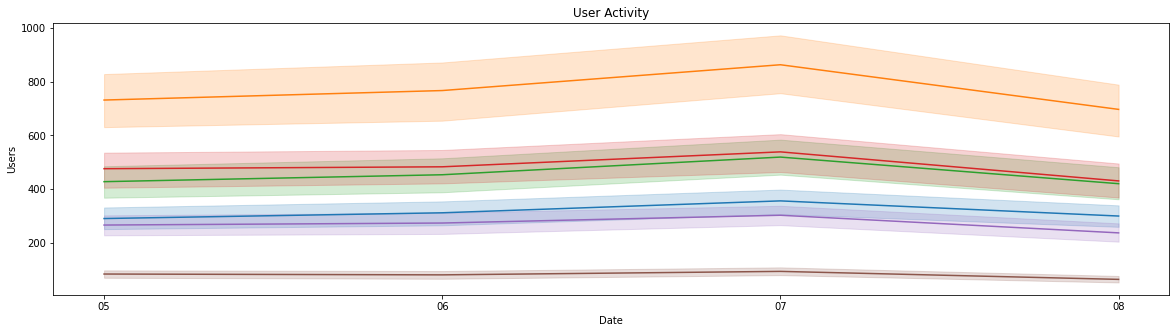

In [12]:
#Graph
plt.subplots(figsize=(20,5))
sns.lineplot(event_action.Month, event_action.Login_count)
sns.lineplot(event_action.Month, event_action.Home_page_count)
sns.lineplot(event_action.Month, event_action.View_inbox_count)
sns.lineplot(event_action.Month, event_action.Like_message_count)
sns.lineplot(event_action.Month, event_action.Send_message_count)
sns.lineplot(event_action.Month, event_action.click_count)
plt.ylabel("Users")
plt.xlabel("Date")
plt.title("User Activity")

In [14]:
q = '''
SELECT DISTINCT device
FROM events
;
''' 
unique_devices = pd.read_sql(q,conn)
unique_devices

device
0   dell inspiron notebook
1                 iphone 5
2                iphone 4s
3          windows surface
4              macbook air
5                iphone 5s
6              macbook pro
7              kindle fire
8                ipad mini
9                  nexus 7
10                 nexus 5
11       samsung galaxy s4
12         lenovo thinkpad
13   samsumg galaxy tablet
14    acer aspire notebook
15         asus chromebook
16                 htc one
17         nokia lumia 635
18     samsung galaxy note
19     acer aspire desktop
20                mac mini
21     hp pavilion desktop
22   dell inspiron desktop
23                ipad air
24       amazon fire phone
25                nexus 10

In [15]:
q = '''
SELECT
CASE WHEN device in ('iphone 5','iphone 4s','iphone 5s','nexus 5','samsung galaxy s4','htc one','nokia lumia 635','samsung galaxy note','amazon fire phone') THEN 'mobile' 
WHEN device in ('windows surface','kindle fire','ipad mini','samsumg galaxy tablet','ipad air','nexus 7','nexus 10') THEN 'Tablet'
WHEN device in ('dell inspiron notebook','macbook air','macbook pro','lenovo thinkpad','acer aspire notebook','asus chromebook','acer aspire desktop','mac mini','hp pavilion desktop','dell inspiron desktop') THEN 'Desktop' END AS device_type,
SUM(engagement_stats.July_Engagement) As July_Engagement,
SUM(engagement_stats.August_Engagement) As August_Engagement,
(SUM(engagement_stats.July_Engagement) - SUM(engagement_stats.August_Engagement))*100.0 / SUM(engagement_stats.July_Engagement) As      Percentage_Change
FROM (SELECT
device,
COUNT(DISTINCT(CASE WHEN strftime('%m', occurred_at) = '07' THEN user_id ELSE NULL END)) as July_Engagement,
COUNT(DISTINCT(CASE WHEN strftime('%m', occurred_at) = '08' THEN user_id ELSE NULL END)) as August_Engagement
FROM events
GROUP BY device) As engagement_stats
GROUP BY device_type
;
''' 
pd.read_sql(q,conn)

device_type  July_Engagement  August_Engagement  Percentage_Change
0     Desktop             3394               3369           0.736594
1      Tablet              908                687          24.339207
2      mobile             2129               1624          23.720056

In [16]:
q = '''
SELECT users.user_id,
COUNT(event_name) as Login_count,
users.activated_at,
strftime('%j', users.activated_at) as Account_Activation_Day,
strftime('%j', events.occurred_at) as Login_Day,
strftime('%j', '2014-09-01 00:00:00') - strftime('%j', users.activated_at) as user_age 
FROM users
INNER JOIN events ON users.user_id  = events.user_id
AND events.event_type = 'engagement'
AND events.event_name = 'login'
GROUP BY users.user_id
;
''' 
pd.read_sql(q,conn)

user_id  Login_count         activated_at Account_Activation_Day  \
0         4.0           16  2013-01-01 14:39:05                    001   
1         8.0            9  2013-01-01 04:40:10                    001   
2        11.0           12  2013-01-01 08:09:17                    001   
3        17.0            5  2013-01-02 10:57:58                    002   
4        19.0            7  2013-01-02 09:55:34                    002   
...       ...          ...                  ...                    ...   
6137  19056.0            1  2014-08-31 16:36:56                    243   
6138  19059.0            1  2014-08-31 19:53:43                    243   
6139  19060.0            1  2014-08-31 12:20:48                    243   
6140  19061.0            1  2014-08-31 13:22:50                    243   
6141  19063.0            1  2014-08-31 07:12:09                    243   

     Login_Day  user_age  
0          133       243  
1          122       243  
2          168       243  
3          211       242  
4          155       242  
...        ...       ...  
6137       243         1  
6138       243         1  
6139       243         1  
6140       243         1  
6141       243         1  

[6142 rows x 6 columns]

In [17]:
q = '''
WITH regions AS(
SELECT user_id,
CASE
    WHEN location IN ('Indonesia', 'Korea', 'Singapore', 'Israel',   'Malaysia', 'Hong Kong', 'Saudi Arabia', 'Philippines', 'Turkey', 'United Arab Emirates', 'Taiwan', 'Thailand', 'India', 'Iran', 'Japan', 'Iraq', 'Russia', 'Pakistan') 
    THEN 'Asia'
    WHEN location IN ('Venezuela', 'Colombia', 'Argentina', 'Chile', 'Brazil') 
    THEN 'South_America'
    WHEN location IN ('Sweden', 'Ireland', 'Portugal', 'Finland', 'France', 'Netherlands', 'Spain', 'Belgium', 'Italy', 'United Kingdom', 'Germany', 'Greece', 'Denmark', 'Switzerland', 'Norway', 'Austria', 'Poland') 
    THEN 'Europe'
    WHEN location IN ('United States', 'Canada', 'Mexico') 
    THEN 'North_America'
    WHEN location IN ('Nigeria', 'Egypt', 'South Africa') 
    THEN 'Africa'
    WHEN location IN ('Australia') 
    THEN 'Oceania'
    ELSE null end as regions,
COUNT(*)
FROM events
WHERE event_type = 'engagement'
GROUP BY 1, 2 
)

SELECT  strftime('%W', events.occurred_at) AS start_week_date, regions,
      COUNT(DISTINCT events.user_id) AS num
FROM events
JOIN regions
ON events.user_id = regions.user_id
GROUP BY 1, 2
'''
pd.read_sql(q,conn)

start_week_date        regions  num
0                17         Africa   11
1                17           Asia  178
2                17         Europe  210
3                17  North_America  245
4                17        Oceania   17
..              ...            ...  ...
103              34           Asia  307
104              34         Europe  365
105              34  North_America  405
106              34        Oceania   25
107              34  South_America   65

[108 rows x 3 columns]

In [18]:
#Graph

## Section 2 - Understanding Search Functionality

How might you (quantitatively) understand the general quality of an individual user's search experience?

- How often the search function is used
- How often the autocomplete is logged
- Is the first search result selected. Relevant posts should appear higher. Ranking algorithm is working efficently if top return result is selected
- Too many clickthroughs (search process too long) can result in poor experience


- search_autocomplete: This is logged when a user clicks on a search option from autocomplete
- search_run: This is logged when a user runs a search and sees the search results page.
- search_click_X: This is logged when a user clicks on a search result. X, which ranges from 1 to 10, describes which search result was clicked


In [19]:
q = '''
SELECT
occurred_at,
strftime('%W', occurred_at) as week_of_year,
COUNT(DISTINCT CASE WHEN event_name = 'search_run' THEN user_id ELSE NULL END) as search_run,
COUNT(DISTINCT CASE WHEN event_name = 'search_autocomplete' THEN user_id ELSE NULL END) as search_autocomplete
FROM events
GROUP BY week_of_year
;
''' 
user_activity = pd.read_sql(q,conn)
user_activity

occurred_at week_of_year  search_run  search_autocomplete
0   2014-05-02 11:02:39           17          86                  200
1   2014-05-09 17:52:45           18         167                  372
2   2014-05-15 13:52:59           19         149                  402
3   2014-05-20 07:29:34           20         168                  412
4   2014-05-28 14:10:56           21         161                  390
5   2014-06-03 15:12:16           22         168                  414
6   2014-06-09 07:06:11           23         177                  422
7   2014-06-20 14:31:18           24         165                  445
8   2014-06-27 18:40:23           25         165                  449
9   2014-07-04 10:33:32           26         175                  449
10  2014-07-12 08:53:20           27         167                  496
11  2014-07-20 12:18:05           28         188                  507
12  2014-07-24 03:49:11           29         185                  498
13  2014-07-30 06:10:40           30         208                  533
14  2014-08-04 23:54:39           31         177                  485
15  2014-08-15 14:03:08           32         152                  429
16  2014-08-20 17:48:44           33         132                  446
17  2014-08-27 11:19:29           34         151                  454

Text(0.5, 1.0, 'User Activity')

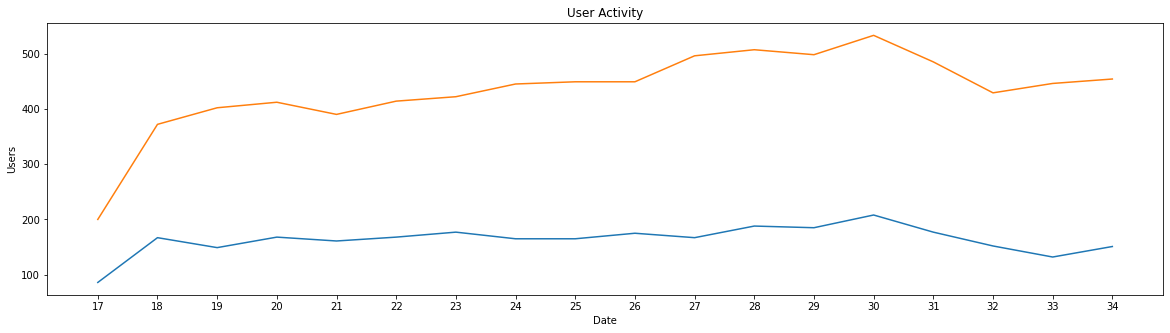

In [20]:
fig, ax = plt.subplots(figsize=(20,5))
sns.lineplot(user_activity.week_of_year, user_activity.search_run, palette="Purples_r")
sns.lineplot(user_activity.week_of_year, user_activity.search_autocomplete, palette="Red")
plt.ylabel("Users")
plt.xlabel("Date")
plt.title("User Activity")

In [21]:
q = '''
SELECT
    occurred_at,
    strftime('%W', occurred_at) as week_of_year,
    COUNT(DISTINCT CASE WHEN event_name = 'search_run' THEN user_id ELSE NULL END)*100.0 / COUNT(DISTINCT user_id) as search_run,
    COUNT(DISTINCT CASE WHEN event_name = 'search_autocomplete' THEN user_id ELSE NULL END)*100.0 / COUNT(DISTINCT user_id) as            search_autocomplete
FROM events
GROUP BY week_of_year
;
''' 
user_activity = pd.read_sql(q,conn)
user_activity

occurred_at week_of_year  search_run  search_autocomplete
0   2014-05-02 11:02:39           17   10.872314            25.284450
1   2014-05-09 17:52:45           18   13.424437            29.903537
2   2014-05-15 13:52:59           19   11.732283            31.653543
3   2014-05-20 07:29:34           20   12.527964            30.723341
4   2014-05-28 14:10:56           21   12.451663            30.162413
5   2014-06-03 15:12:16           22   12.298682            30.307467
6   2014-06-09 07:06:11           23   12.343096            29.428173
7   2014-06-20 14:31:18           24   11.285910            30.437756
8   2014-06-27 18:40:23           25   11.434511            31.115731
9   2014-07-04 10:33:32           26   11.848341            30.399458
10  2014-07-12 08:53:20           27   10.732648            31.876607
11  2014-07-20 12:18:05           28   12.082262            32.583548
12  2014-07-24 03:49:11           29   11.613308            31.261770
13  2014-07-30 06:10:40           30   12.344214            31.632047
14  2014-08-04 23:54:39           31   11.935266            32.703978
15  2014-08-15 14:03:08           32   10.570236            29.833102
16  2014-08-20 17:48:44           33    9.348442            31.586402
17  2014-08-27 11:19:29           34   10.471567            31.484050

Text(0.5, 1.0, 'User Activity')

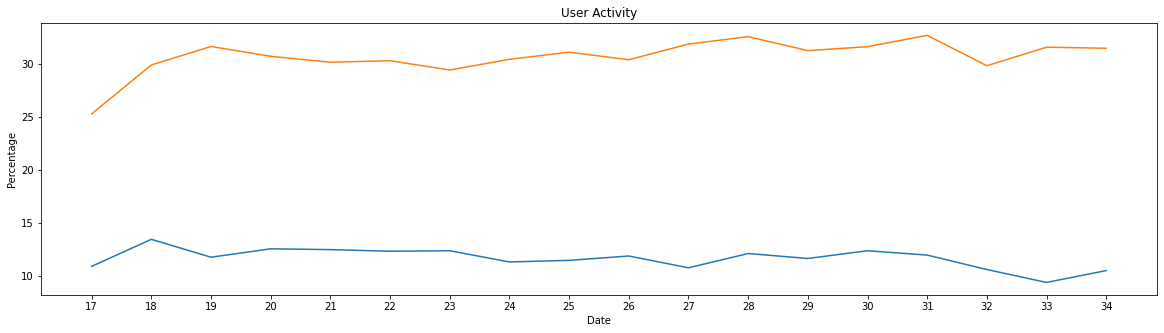

In [22]:
fig, ax = plt.subplots(figsize=(20,5))
sns.lineplot(user_activity.week_of_year, user_activity.search_run, palette="Purples_r")
sns.lineplot(user_activity.week_of_year, user_activity.search_autocomplete, palette="Red")
plt.ylabel("Percentage")
plt.xlabel("Date")
plt.title("User Activity")

In [23]:
q = '''
SELECT
    user_id,
    COUNT(new_session)
FROM (
    SELECT
    user_id,
    event_name,
    LAG(event_name, 1) OVER (ORDER BY user_id) AS lag_event,
    occurred_at,
    LAG(occurred_at, 1) OVER (ORDER BY user_id) AS lag_time,
    CASE WHEN (strftime('%s', occurred_at) - strftime('%s', LAG(occurred_at, 1) OVER (ORDER BY user_id))) / 60 > 10 THEN 'TRUE' ELSE      'FALSE' END AS new_session
FROM events
ORDER BY user_id) As s
GROUP BY user_id, s.new_session
;
''' 
pd.read_sql(q,conn)
#COUNT(CASE WHEN event_name = 'search_run' AND Sessions.Diff = 'NEW SESS' THEN Diff ELSE NULL END) As Count
# 1Session|2Session|3Session

user_id  COUNT(new_session)
0          4.0                  80
1          4.0                  13
2          8.0                  28
3          8.0                   8
4         11.0                 115
...        ...                 ...
15519  19062.0                   1
15520  19062.0                   1
15521  19063.0                  12
15522  19064.0                   1
15523  19065.0                   1

[15524 rows x 2 columns]

In [24]:
q = '''
WITH cte AS (
    SELECT
    t.user_id,
    t.event_name,
    t.occurred_at,
    t.lag_time,
    t.Diff,
    SUM(t.Diff) OVER (PARTITION BY t.user_id ORDER BY t.occurred_at) AS session_id
FROM (
    SELECT
    user_id,
    event_name,
    LAG(event_name, 1) OVER (PARTITION BY user_id ORDER BY user_id) AS lag_event,
    occurred_at,
    LAG(occurred_at, 1, 0) OVER (PARTITION BY user_id ORDER BY user_id) AS lag_time,
    CASE WHEN (strftime('%s', occurred_at) - strftime('%s', LAG(occurred_at, 1, 0) OVER (PARTITION BY user_id ORDER BY user_id, occurred_at))) / 60 > 10 THEN 1 ELSE 0 END AS Diff
FROM events
ORDER BY user_id) t)

SELECT
    session_id,
    COUNT(CASE WHEN event_name = 'search_run' THEN event_name ELSE NULL END) as search_run_count
FROM cte
GROUP BY session_id
;
''' 

run_count = pd.read_sql(q,conn).head(10)
run_count

session_id  search_run_count
0           1              2158
1           2              1776
2           3              1486
3           4              1321
4           5               955
5           6               746
6           7               647
7           8               544
8           9               472
9          10               434

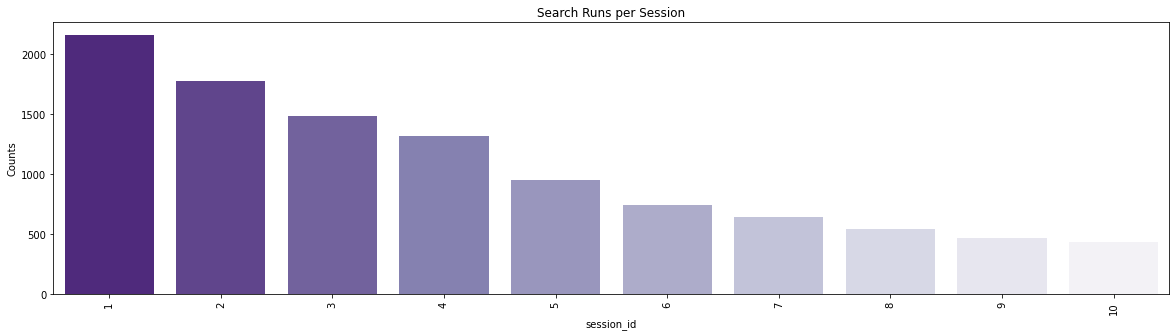

In [25]:
plt.figure(figsize=(20,5))
sns.barplot(run_count.session_id, run_count.search_run_count, palette="Purples_r")
plt.ylabel("Counts")
plt.title("Search Runs per Session");
plt.xticks(rotation=90);

In [26]:
q = '''
WITH cte AS (
SELECT
    t.user_id,
    t.event_name,
    t.occurred_at,
    t.lag_time,
    t.Diff,
    SUM(t.Diff) OVER (PARTITION BY t.user_id ORDER BY t.occurred_at) AS session_id
FROM (
    SELECT
    user_id,
    event_name,
    LAG(event_name, 1) OVER (PARTITION BY user_id ORDER BY user_id) AS lag_event,
    occurred_at,
    LAG(occurred_at, 1, 0) OVER (PARTITION BY user_id ORDER BY user_id) AS lag_time,
    CASE WHEN (strftime('%s', occurred_at) - strftime('%s', LAG(occurred_at, 1, 0) OVER (PARTITION BY user_id ORDER BY user_id,           occurred_at))) / 60 >= 10 THEN 1 ELSE 0 END AS Diff
FROM events
ORDER BY user_id) t)

SELECT
    session_id,
    COUNT(CASE WHEN event_name = 'search_autocomplete' THEN event_name ELSE NULL END) as search_autocomplete_count
FROM cte
GROUP BY session_id
;
''' 

autocomplete_count = pd.read_sql(q,conn).head(10)
autocomplete_count

session_id  search_autocomplete_count
0           1                       2879
1           2                       2503
2           3                       2054
3           4                       1631
4           5                       1371
5           6                       1111
6           7                       1054
7           8                        747
8           9                        677
9          10                        525

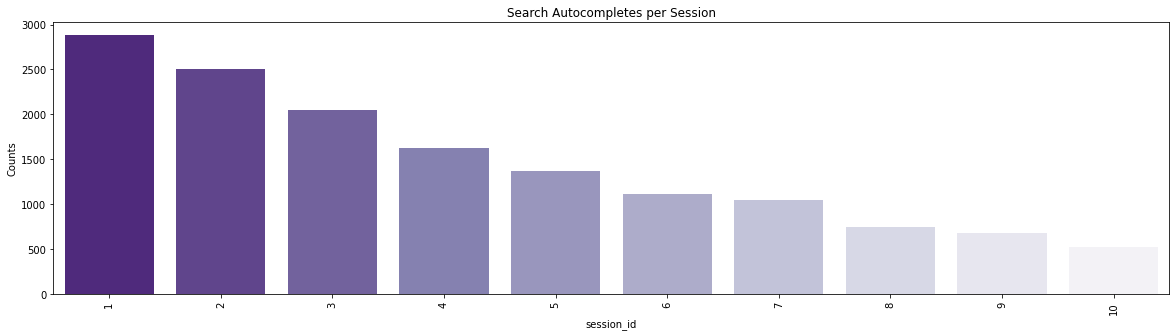

In [27]:
plt.figure(figsize=(20,5))
sns.barplot(autocomplete_count.session_id, autocomplete_count.search_autocomplete_count, palette="Purples_r")
plt.ylabel("Counts")
plt.title("Search Autocompletes per Session");
plt.xticks(rotation=90);

In [28]:
q = '''
SELECT
    event_name,
    COUNT(user_id)
FROM events
WHERE event_name LIKE '%search_click%'
GROUP BY event_name
;
''' 

search_click = pd.read_sql(q,conn)
search_click
#search_click_results_2 is the highest

event_name  COUNT(user_id)
0   search_click_result_1            1413
1  search_click_result_10             506
2   search_click_result_2            1499
3   search_click_result_3            1134
4   search_click_result_4            1264
5   search_click_result_5             968
6   search_click_result_6             805
7   search_click_result_7             709
8   search_click_result_8             690
9   search_click_result_9             784

## Section 3 - Validating A/B Test Results

How might you (quantitatively) understand the general quality of an individual user's search experience?

On July 1, you check the results of the A/B test. You notice that message posting is 50% higher in the treatment group—a huge increase in posting. The table below summarizes the results:


Before doing anything with the data, develop some hypotheses about why the result might look the way it does, as well as methods for testing those hypotheses. As a point of reference, such dramatic changes in user behavior—like the 50% increase in posting—are extremely uncommon.

- This metric is incorrect or irrelevant
- The test was calculated incorrectly
- The users were treated incorrectly
- There is a confounding factor or interaction effect

In [29]:
q = """
SELECT 
    events.user_id, 
    events.occurred_at, 
    events.event_type, 
    events.event_name
FROM experiments
INNER JOIN events
ON experiments.user_id = events.user_id
WHERE events.occurred_at <= '2014-07-01' AND experiments.occurred_at >= '2014-06-01'
ORDER BY events.occurred_at DESC
;
"""

sorted_events = pd.read_sql(q,conn)
sorted_events.head()

user_id          occurred_at  event_type    event_name
0  14893.0  2014-06-30 23:47:04  engagement  like_message
1  14893.0  2014-06-30 23:46:40  engagement     home_page
2  14893.0  2014-06-30 23:46:10  engagement  send_message
3  14893.0  2014-06-30 23:45:43  engagement  like_message
4  14893.0  2014-06-30 23:45:14  engagement    view_inbox

In [30]:
q = """
SELECT 
user_id, 
experiment_group
FROM experiments;
"""
experiment_group = pd.read_sql(q,conn)
experiment_group.head()

user_id experiment_group
0      4.0    control_group
1   8198.0    control_group
2     11.0    control_group
3   8209.0       test_group
4     19.0       test_group

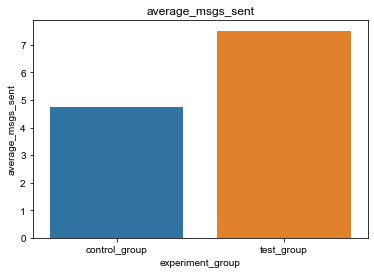

experiment experiment_group  users  total_treated_users  \
0  publisher_update    control_group   1746                 2595   
1  publisher_update       test_group    849                 2595   

     treatment_%  total_msgs_sent  average_msgs_sent   std_dev     t_stat  \
0  control_group           8288.0            4.74685  4.191992   0.000000   
1     test_group           6377.0            7.51119  5.528611  12.872769   

        p_value  
0  1.000000e+00  
1  7.810399e-36

In [31]:
dfc = sorted_events.groupby('user_id')['event_name'].value_counts()
dfc2 = pd.DataFrame(dfc)
dfc2.columns = ['frequency']
dfc3 = dfc2.unstack(level=1)

def ab_test(metric, graph_title_avg):
    dfc4 = dfc3[[('frequency', metric)]]
    dfc4.columns = [metric]
    dfc4 = dfc4.reset_index()
    dfc5 = experiment_group.merge(dfc4, how='left', on='user_id').fillna(0)

    #t-test
    control_df = dfc5[dfc5.experiment_group == 'control_group']
    test_df = dfc5[dfc5.experiment_group == 'test_group']
    t_test = stats.ttest_ind(test_df[metric], control_df[metric], equal_var=False)

    d = {
        'experiment': ['publisher_update', 'publisher_update'],
        'experiment_group': ['control_group', 'test_group'],
        'users': [len(control_df), len(test_df)],
        'total_treated_users': [len(dfc5.index), len(dfc5.index)],
        'treatment_%': [len(control_df)/len(dfc5.index), len(test_df)/len(dfc5.index)],
        'total_msgs_sent': [control_df[metric].sum(), test_df[metric].sum()],
        'average_msgs_sent': [control_df[metric].mean(), test_df[metric].mean()],
        'treatment_%': ['control_group', 'test_group'],
        'std_dev': [np.std(control_df[metric]), np.std(test_df[metric])],
        't_stat': [0, t_test.statistic], 'p_value': [1 - t_test.pvalue, t_test.pvalue]
        }

    summary = pd.DataFrame(d, columns=d)
    ax = sns.barplot(x="experiment_group", y=graph_title_avg, data=summary)
    ax.set_title(graph_title_avg)
    sns.set(rc={'figure.figsize':(10,8)})
    plt.show()
    return summary
    
ab_test('login', 'average_msgs_sent')
